# U.S. Geological Survey Class GW3099

Advanced Modeling of Groundwater Flow (GW3099) <br>
Boise, Idaho <br>
September 16 - 20, 2024 <br>

# ![title](../../images/ClassLocation.jpg)

# PRT example 1: backwards tracking in steady flow field

![title](../../images/ex-prt-mp7-p01-config.png)

This notebook demonstrates backwards tracking in a steady-state flow field. First a MODFLOW 6 PRT model and an equivalent MODPATH 7 model are run side-by-side, and their results compared. We then refine the grid around the release location and rerun the model to demonstrate the effects of a modified discretization.

Import dependencies.

In [1]:
import pathlib as pl
import flopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from flopy.utils.gridgen import Gridgen
from flopy.utils.gridintersect import GridIntersect
from flopy.utils.triangle import Triangle as Triangle
from shapely.geometry import LineString, MultiPoint


Enable inline plotting.

In [2]:

%matplotlib inline

Ignore some warnings.

In [3]:
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", DeprecationWarning)

Make sure extra executables are installed. We assume MF6 is already installed.

In [4]:
flopy.utils.get_modflow(":python", subset="mp7,gridgen,triangle")

auto-selecting option ':python' for 'bindir'
fetched release '19.0' info from MODFLOW-USGS/executables
using previous download '/Users/wbonelli/Downloads/modflow_executables-19.0-macarm.zip' (use 'force=True' to re-download)
extracting 3 files to '/Users/wbonelli/micromamba/envs/gw3099/bin'
gridgen (1.0.02) mp7 (7.2.001)    triangle (1.6)
updated flopy metadata file: '/Users/wbonelli/.local/share/flopy/get_modflow.json'


Create a base workspace.

In [5]:
example_name = "prt_mp7_ex2"
base_ws = pl.Path("temp") / example_name
base_ws.mkdir(exist_ok=True, parents=True)

## Flow model

First we define a flow model which will be used by PRT and MP7.

Define the flow model name and workspace.

In [6]:
gwf_name = f"{example_name}-gwf"
gwf_ws = base_ws / "gwf"
gwf_ws.mkdir(exist_ok=True, parents=True)

Define flow model units.

In [7]:
length_units = "feet"
time_units = "days"

Define flow model parameters.

In [8]:
nper = 1  # Number of periods
nlay = 3  # Number of layers (base grid)
nrow = 21  # Number of rows (base grid)
ncol = 20  # Number of columns (base grid)
delr = 500.0  # Column width ($ft$)
delc = 500.0  # Row width ($ft$)
top = 400.0  # Top of the model ($ft$)
botm = [220.0, 200.0, 0.0]  # Layer bottom elevations ($ft$)
porosity = 0.1  # Soil porosity (unitless)
rch = 0.005  # Recharge rate ($ft/d$)
kh = [50.0, 0.01, 200.0]  # Horizontal hydraulic conductivity ($ft/d$)
kv = [10.0, 0.01, 20.0]  # Vertical hydraulic conductivity ($ft/d$)
wel_q = -150000.0  # Well pumping rate ($ft^3/d$)
riv_h = 320.0  # River stage ($ft$)
riv_z = 317.0  # River bottom ($ft$)
riv_c = 1.0e5  # River conductance ($ft^2/d$)

Define the initial structured grid. Later we will refine the grid, but for the first run we use a coarse discretization.

In [9]:
Lx = 10000.0
Ly = 10500.0
nlay = 3
nrow = 21
ncol = 20
delr = Lx / ncol
delc = Ly / nrow
top = 400
botm = [220, 200, 0]

Define the time discretization.

In [10]:
nstp = 1
perlen = 1000.0
tsmult = 1.0
tdis_rc = [(perlen, nstp, tsmult)]

Construct a simulation for the flow model.

In [11]:
gwf_sim = flopy.mf6.MFSimulation(
    sim_name=gwf_name, exe_name="mf6", version="mf6", sim_ws=gwf_ws
)

Create the time discretization.

In [12]:
tdis = flopy.mf6.ModflowTdis(
    gwf_sim, pname="tdis", time_units="DAYS", perioddata=tdis_rc, nper=len(tdis_rc)
)

Create the flow model.

In [13]:
gwf = flopy.mf6.ModflowGwf(
    gwf_sim, modelname=gwf_name, model_nam_file=f"{gwf_name}.nam"
)
gwf.name_file.save_flows = True

Create the discretization package.

In [14]:
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm
)

Create the initial conditions package.

In [15]:
ic = flopy.mf6.ModflowGwfic(gwf, pname="ic", strt=top)  # initial heads at river stage

Create the node property flow package.

In [16]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=[1, 0, 0],
    k=kh,
    k33=kv,
    save_saturation=True,
    save_specific_discharge=True,
)

Define the model's boundary conditions. These include a well, a river, and recharge.

In [17]:
# Well package
wel_loc = (2, 10, 9)
wd = [(wel_loc, wel_q)]

# River package
riv_iface = 6
riv_iflowface = -1
rd = []
for i in range(nrow):
    rd.append([(0, i, ncol - 1), riv_h, riv_c, riv_z, riv_iface, riv_iflowface])

# Recharge package
rch_iface = 6
rch_iflowface = -1

Define well and river cell numbers, used to extract and plot model results later.

In [18]:
nodes = {}
k, i, j = wel_loc
nodes["well"] = [ncol * (nrow * k + i) + j]
nodes["river"] = []
for rivspec in rd:
    k, i, j = rivspec[0]
    node = ncol * (nrow * k + i) + j
    nodes["river"].append(node)

Create the recharge, well, and river packages.

In [19]:
# Instantiate the MODFLOW 6 gwf recharge package
rcha = flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(
    gwf,
    recharge=rch,
    auxiliary=["iface", "iflowface"],
    aux=[rch_iface, rch_iflowface],
)

# Instantiate the MODFLOW 6 gwf well package
wel = flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
    gwf, maxbound=1, stress_period_data={0: wd}
)

# Instantiate the MODFLOW 6 gwf river package
riv = flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
    gwf, auxiliary=["iface", "iflowface"], stress_period_data={0: rd}
)

Create the output control package.

In [20]:
# Define output file names
headfile_name = f"{gwf_name}.hds"
budgetfile_name = f"{gwf_name}.cbb"

# Create package
head_record = [headfile_name]
budget_record = [budgetfile_name]
saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
    gwf,
    pname="oc",
    saverecord=saverecord,
    head_filerecord=head_record,
    budget_filerecord=budget_record,
)

Create the solver package.

In [21]:
ims = flopy.mf6.ModflowIms(
    gwf_sim,
    pname="ims",
    complexity="SIMPLE",
    outer_dvclose=1e-6,
    inner_dvclose=1e-6,
    rcloserecord=1e-6,
)

Write and run the flow model.

In [22]:
gwf_sim.write_simulation(silent=False)
gwf_sim.run_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model prt_mp7_ex2-gwf...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package wel_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../../micromamba/envs/gw3099/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 09/12/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Sep 12 2024 02:49:12 with GCC version 13.3.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet t

(True, [])

Load heads.

In [23]:
hds = gwf.output.head().get_data()

Plot heads. Define a function for it which we will reuse later.

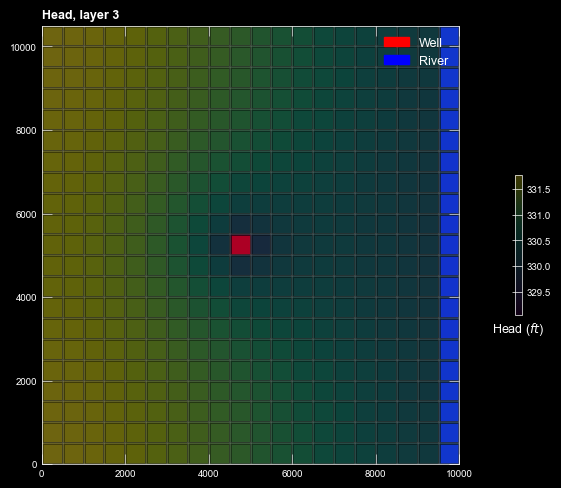

In [24]:
from matplotlib.patches import Patch


def plot_heads(ax, gwf, heads):
    mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=2)
    mm.plot_grid(alpha=0.25)
    mm.plot_bc("WEL", plotAll=True, color="red")
    mm.plot_bc("RIV", plotAll=True, color="blue")
    pc = mm.plot_array(heads, edgecolor="black", alpha=0.25)
    cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
    cb.ax.set_xlabel(r"Head ($ft$)")
    return mm

with flopy.plot.styles.USGSPlot():
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.set_aspect("equal")
    ax.legend(
            handles=[
                Patch(color="red", label="Well"),
                Patch(color="blue", label="River"),
            ],
        )
    fig.tight_layout()
    flopy.plot.styles.heading(ax, heading="Head, layer 3")
    plot_heads(ax, gwf, hds[2, :, :])
    plt.show()

## Tracking models

We now define a MODPATH 7 particle tracking simulation, then an equivalent PRT simulation.

### MP7 model

Define the MP7 model name and workspace.

In [25]:
mp7_name = f"{example_name}-mp7"
mp7_ws = base_ws / "mp7"
mp7_ws.mkdir(exist_ok=True, parents=True)

The next step is to define a particle release configuration. We will release particles from the lateral faces of the cell containing the well.

In [26]:
mp7_face_data = flopy.modpath.FaceDataType(
    drape=0,
    rowdivisions5=0,
    rowdivisions6=0,
    columndivisions5=0,
    columndivisions6=0
)
mp7_particle_data = flopy.modpath.LRCParticleData(
    subdivisiondata=[mp7_face_data],
    lrcregions=[[[2, 10, 9, 2, 10, 9]]]
)

Now we can create the MP7 model. First define the expected pathline output file.

In [27]:
mp7_pathline_file_path = mp7_ws / f"{mp7_name}.mppth"

Create the model object.

In [28]:
mp7 = flopy.modpath.Modpath7(
    modelname=mp7_name,
    flowmodel=gwf,
    exe_name="mp7",
    model_ws=mp7_ws,
    budgetfilename=budgetfile_name,
    headfilename=headfile_name,
)

Create the MP7 basic input data package.

In [29]:
mp7_bas = flopy.modpath.Modpath7Bas(mp7, porosity=porosity, defaultiface={"RCH": 6, "EVT": 6})

Create the MP7 particle group.

In [30]:
mp7_pg1 = flopy.modpath.ParticleGroupLRCTemplate(
    particlegroupname="PG1",
    particledata=mp7_particle_data,
    filename=mp7_name + "pg1.sloc",
)

Define a zone (`izone`) mapping for boundary conditions. MP7 and PRT will assign each particle pathline record to a zone. This allows easier identification of capture areas.

In [31]:
izone = np.zeros((nlay, nrow, ncol), dtype=int)
for l, r, c in gwf.modelgrid.get_lrc(nodes["well"]):
    izone[l, r, c] = 1
for l, r, c in gwf.modelgrid.get_lrc(nodes["river"]):
    izone[l, r, c] = 2

Create the MP7 simulation.

In [32]:
mp7_sim = flopy.modpath.Modpath7Sim(
    mp7,
    simulationtype="combined",
    trackingdirection="backward",
    weaksinkoption="pass_through",
    weaksourceoption="pass_through",
    budgetoutputoption="summary",
    referencetime=[0, 0, 0.0],
    stoptimeoption="extend",
    timepointdata=[500, 1000.0],
    zonedataoption="on",
    zones=izone,
    particlegroups=[mp7_pg1],
)

Run the MP7 simulation.

In [33]:
mp7.write_input()
mp7.run_model(silent=False)

FloPy is using the following executable to run the model: ../../../../../../../micromamba/envs/gw3099/bin/mp7

MODPATH Version 7.2.001   
Program compiled Jun 21 2024 02:56:57 with GFORTRAN compiler (ver. 12.3.0)      


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+03  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
        36 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
         0 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

Load MP7 pathline results. FloPy returns a list of `np.recarray`, one for each pathline; we merge the pathlines into a single dataframe. We also do a bit of post-processing to add release time and termination time columns.

In [34]:
mp7_pathline_file = flopy.utils.PathlineFile(mp7_pathline_file_path)
mp7_pathlines = pd.concat([pd.DataFrame(pl) for pl in  mp7_pathline_file.get_alldata()])
mp7_pathlines

,particleid,particlegroup,sequencenumber,particleidloc,time,x,y,z,k,node,xloc,yloc,zloc,stressperiod,timestep
0,0,0,0,0,0.000000,4500.000000,5083.333496,33.333332,2,1049,0.000000,0.166667,0.166667,1,1
1,0,0,0,0,0.000000,4500.000000,5083.333496,33.333332,2,1049,0.000000,0.166667,0.166667,1,1
2,0,0,0,0,100.119873,4160.078125,5000.000000,33.892811,2,1048,0.320156,0.000000,0.169464,1,1
3,0,0,0,0,215.377319,4000.000000,4883.588867,34.524174,2,1068,0.000000,0.767177,0.172621,1,1
4,0,0,0,0,620.646973,3500.000000,4714.717285,36.908764,2,1067,0.000000,0.429435,0.184544,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,35,0,35,35,3076.845947,4000.000000,7052.240723,253.561340,0,128,0.000000,0.104481,0.287246,1,1
12,35,0,35,35,4000.000000,3549.744873,7067.121582,290.191925,0,127,0.099490,0.134243,0.598071,1,1
13,35,0,35,35,4110.804688,3500.000000,7068.907227,294.941925,0,127,0.000000,0.137815,0.638543,1,1
14,35,0,35,35,5000.000000,3130.339600,7081.286621,336.799500,0,126,0.260679,0.162573,0.991438,1,1


Plot MP7 results.

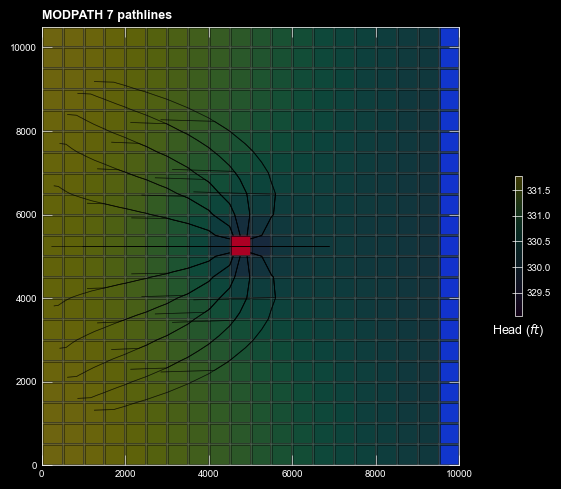

In [35]:
with flopy.plot.styles.USGSPlot():
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.set_aspect("equal")
    fig.tight_layout()
    flopy.plot.styles.heading(ax, heading="MODPATH 7 pathlines")
    mm = plot_heads(ax, gwf, hds[2, :, :])
    mm.plot_pathline(mp7_pathlines, layer="all", colors="black", alpha=0.5, linewidth=0.5)
    plt.show()



### PRT model

Define the PRT model name and workspace.

In [36]:
prt_name = f"{example_name}-prt"
prt_ws = base_ws / "prt"
prt_ws.mkdir(exist_ok=True, parents=True)

Create a PRT simulation.

In [37]:
prt_sim = flopy.mf6.MFSimulation(
    sim_name=prt_name, exe_name="mf6", version="mf6", sim_ws=prt_ws
)

Create the temporal discretization.

In [38]:
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
    prt_sim,
    pname="tdis",
    time_units="DAYS",
    nper=nper,
    perioddata=[(perlen, nstp, tsmult)],
)

Create the PRT model.

In [39]:
prt = flopy.mf6.ModflowPrt(
    prt_sim, modelname=prt_name, model_nam_file=f"{prt_name}.nam"
)

Create the discretization package.

In [40]:
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
    prt,
    pname="dis",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    length_units="FEET",
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

Create the PRT model input package.

In [41]:
mip = flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity, izone=izone)

Create the particle release package. We will use a conversion utility which makes it easy to convert a MODPATH 7 particle release configuration to the format expected by PRT's particle release point (PRP) package.

In [42]:
release_pts = list(mp7_particle_data.to_prp(gwf.modelgrid))
prp = flopy.mf6.ModflowPrtprp(
    prt,
    # filename=f"{prt_name}1.prp",
    nreleasepts=len(release_pts),
    packagedata=release_pts,
    perioddata={
        0: ["FIRST"],
    },
    exit_solve_tolerance=1e-5,
    extend_tracking=True,
)

Create the output control package.

In [43]:
# Define output files.
budgetfile_prt = f"{prt_name}.cbb"
trackfile_prt = f"{prt_name}.trk"
trackhdrfile_prt = f"{prt_name}.trk.hdr"
trackcsvfile_prt = f"{prt_name}.trk.csv"

# Define the output control package.
budget_record = [budgetfile_prt]
track_record = [trackfile_prt]
trackcsv_record = [trackcsvfile_prt]
tracktimes = list(range(0, 72000, 1000))
oc = flopy.mf6.ModflowPrtoc(
    prt,
    pname="oc",
    budget_filerecord=budget_record,
    track_filerecord=track_record,
    trackcsv_filerecord=trackcsv_record,
    ntracktimes=len(tracktimes),
    tracktimes=[(t,) for t in tracktimes],
    saverecord=[("BUDGET", "ALL")],
)

Create the flow model interface. Since PRT does not yet support backwards tracking natively, we'll reverse the flow model's head and budget output files with FloPy first.

In [44]:
head_file = flopy.utils.HeadFile(gwf_ws / headfile_name, tdis=gwf_sim.tdis)
budget_file = flopy.utils.CellBudgetFile(gwf_ws / budgetfile_name, precision="double", tdis=gwf_sim.tdis)

headfile_bkwd_name = f"{headfile_name}_bkwd"
budgetfile_bkwd_name = f"{budgetfile_name}_bkwd"

head_file.reverse(prt_ws / headfile_bkwd_name)
budget_file.reverse(prt_ws / budgetfile_bkwd_name)

fmi = flopy.mf6.ModflowPrtfmi(prt, packagedata=[
    ("GWFHEAD", pl.Path(f"../{prt_ws.name}/{headfile_bkwd_name}")),
    ("GWFBUDGET", pl.Path(f"../{prt_ws.name}/{budgetfile_bkwd_name}")),
])

Create an explicit model solution for the PRT model.

In [45]:
ems = flopy.mf6.ModflowEms(
    prt_sim,
    pname="ems",
    filename=f"{prt_name}.ems",
)
prt_sim.register_solution_package(ems, [prt.name])

Write and run the PRT model.

In [46]:
prt_sim.write_simulation()
prt_sim.run_simulation(silent=False)

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ems...
  writing model prt_mp7_ex2-prt...
    writing model name file...
    writing package dis...
    writing package mip...
    writing package prp_0...
    writing package oc...
    writing package fmi...
FloPy is using the following executable to run the model: ../../../../../../../micromamba/envs/gw3099/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.6.0.dev0 (preliminary) 09/12/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Sep 12 2024 02:49:12 with GCC version 13.3.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
b

(True, [])

Load the PRT pathlines.

In [47]:
prt_pathlines = pd.read_csv(prt_ws / trackcsvfile_prt)
prt_pathlines

,kper,kstp,imdl,iprp,irpt,ilay,icell,izone,istatus,ireason,trelease,t,x,y,z,name
0,1,1,1,1,1,3,1050,1,1,0,0.0,0.000000,4500.000000,5083.333333,66.666667,NaN
1,1,1,1,1,1,3,1050,1,1,1,0.0,0.000000,4500.000000,5083.333333,66.666667,NaN
2,1,1,1,1,1,3,1049,0,1,5,0.0,0.000000,4500.000000,5083.333333,66.666667,NaN
3,1,1,1,1,1,3,1049,0,1,1,0.0,100.119874,4160.077871,5000.000000,67.785623,NaN
4,1,1,1,1,1,3,1069,0,1,1,0.0,215.377315,4000.000000,4883.588651,69.048348,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,1,1,1,1,36,1,189,0,1,1,0.0,2153.059546,4000.000000,5512.397884,273.364877,NaN
665,1,1,1,1,36,1,188,0,1,5,0.0,3000.000000,3578.684236,5516.456802,310.330484,NaN
666,1,1,1,1,36,1,188,0,1,1,0.0,3171.595022,3500.000000,5517.284739,318.336923,NaN
667,1,1,1,1,36,1,187,0,1,1,0.0,3563.081612,3328.612852,5518.656759,337.773174,NaN


Plot the PRT pathlines superimposed over the MP7 pathlines, this time in 3D with PyVista.

The first step is to export the models to VTK.

In [48]:
from flopy.export.vtk import Vtk

vert_exag = 10

vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=False)
vtk.add_model(gwf)
vtk.add_pathline_points(mp7_pathlines.to_records(index=False))
gwf_mesh, mp7_mesh = vtk.to_pyvista()

# this is a little awkward due to the design of `Vtk`, which can only
# have one set of pathlines at a time. 
vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=False)
vtk.add_model(gwf)
vtk.add_pathline_points(prt_pathlines.to_records(index=False))
_, prt_mesh = vtk.to_pyvista()

Create meshes to show the confining bed and boundary conditions.

In [49]:
def get_nn(k, i, j):
    """Convert a structured grid cell index to a node number."""
    return k * nrow * ncol + i * ncol + j

import pyvista as pv

riv_mesh = pv.Box(
    bounds=[
        gwf.modelgrid.extent[1] - delc,
        gwf.modelgrid.extent[1],
        gwf.modelgrid.extent[2],
        gwf.modelgrid.extent[3],
        botm[0] * vert_exag,
        hds[(0, 0, ncol - 1)] * vert_exag,
    ]
)
well_cellid = get_nn(0, *wel_loc[1:])
well_points = gwf.modelgrid.verts[gwf.modelgrid.iverts[well_cellid]]
well_xs, well_ys = list(zip(*well_points))
wel_mesh = pv.Box(bounds=[
    min(well_xs),
    max(well_xs),
    min(well_ys),
    max(well_ys),
    botm[-1] * vert_exag,
    botm[-2] * vert_exag])
bed_mesh = pv.Box(
    bounds=[
        gwf.modelgrid.extent[0],
        gwf.modelgrid.extent[1],
        gwf.modelgrid.extent[2],
        gwf.modelgrid.extent[3],
        botm[1] * vert_exag,
        botm[0] * vert_exag,
    ]
)

Create the 3D plot.

In [50]:
axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)
pv.set_jupyter_backend("trame")
p = pv.Plotter(
    window_size=[500, 500],
    notebook=True,
)
p.enable_anti_aliasing()
p.add_mesh(gwf_mesh, opacity=0.025, style="wireframe")
# p.add_mesh(
#     mp7_mesh,
#     point_size=4,
#     line_width=3,
#     render_points_as_spheres=True,
#     render_lines_as_tubes=True,
#     smooth_shading=True,
#     color="red"
# )
p.add_mesh(
    prt_mesh,
    point_size=4,
    line_width=3,
    render_points_as_spheres=True,
    render_lines_as_tubes=True,
    smooth_shading=True,
    color="blue"
)
p.add_mesh(riv_mesh, color="teal", opacity=0.2)
p.add_mesh(wel_mesh, color="red", opacity=0.3)
p.add_mesh(bed_mesh, color="tan", opacity=0.1)
p.show()

Widget(value='<iframe src="http://localhost:53579/index.html?ui=P_0x2b8918fd0_0&reconnect=auto" class="pyvista…

## Grid refinement

We will now refine the grid around the particle release location, then rerun the tracking model to witness the effect on pathlines.

First create a GRIDGEN object wrapping the original structured grid.

In [ ]:
gridgen_ws = base_ws / "gridgen"
gridgen_ws.mkdir(parents=True, exist_ok=True)
gridgen = Gridgen(gwf.modelgrid, model_ws=gridgen_ws)

Define refinement polygons.

In [ ]:
ref_polys = [
    [[(3500, 4000), (3500, 6500), (6000, 6500), (6000, 4000), (3500, 4000)]],  # outer
    [[(4000, 4500), (4000, 6000), (5500, 6000), (5500, 4500), (4000, 4500)]],  # middle
    [[(4500, 5000), (4500, 5500), (5000, 5500), (5000, 5000), (4500, 5000)]],  # inner
]
ref_paths = []
for i, poly in enumerate(ref_polys):
    gridgen.add_refinement_features([poly], "polygon", i + 1, range(nlay))
    ref_paths.append(gridgen_ws / f"rf{i}")

Build the refined grid.

In [ ]:
gridgen.build(verbose=False)
grid_props = gridgen.get_gridprops_vertexgrid()
disv_props = gridgen.get_gridprops_disv()
grid = flopy.discretization.VertexGrid(**grid_props)

Extract refined grid properties.

In [ ]:
ncpl = disv_props["ncpl"]
top = disv_props["top"]
botm = disv_props["botm"]
nvert = disv_props["nvert"]
vertices = disv_props["vertices"]
cell2d = disv_props["cell2d"]

Plot the grid with refinement levels superimposed.

In [ ]:
grid.plot()
for i, path in enumerate(ref_paths):
    flopy.plot.plot_shapefile(path, ax=plt.gca(), facecolor="green", edgecolor="none", alpha=(i + 1) / 3)
plt.show()

We can now modify the flow model simulation above:

1. Detach the structured grid discretization
2. Attach the refined grid discretization
3. Add the particle tracking model
4. Add a GWF-PRT model exchange

In [ ]:
sim = gwf_sim
sim.remove_package("dis")
disv = flopy.mf6.ModflowGwfdisv(
    gwf,
    length_units=length_units,
    **disv_props,  # from grid refinement above
)

Define the model's boundary conditions. These include a well, a river, and recharge. Instead of manually setting cell IDs for the well and river, we will determine cell IDs by defining boundary coordinates and intersecting them with the grid.

In [21]:
ix = GridIntersect(gwf.modelgrid, method="vertex", rtree=True)

Create the well package.

In [23]:
wel_coords = [(4718.45, 5281.25)]
welcells = ix.intersects(MultiPoint(wel_coords))
welcells = [icpl for (icpl,) in welcells]
welspd = [[(2, icpl), -150000.0] for icpl in welcells]
wel = flopy.mf6.ModflowGwfwel(gwf, print_input=True, stress_period_data=welspd)

Create the river package.

In [24]:
riv_iface = 6
riv_iflowface = -1
riverline = [(Lx - 1.0, Ly), (Lx - 1.0, 0.0)]
rivcells = ix.intersects(LineString(riverline))
rivcells = [icpl for (icpl,) in rivcells]
rivspd = [
    [(0, icpl), riv_h, riv_c, riv_z, riv_iface, riv_iflowface] for icpl in rivcells
]
riv = flopy.mf6.ModflowGwfriv(
    gwf, stress_period_data=rivspd, auxiliary=[("iface", "iflowface")]
)

IndexError: tuple index out of range

Create the recharge package.

In [ ]:
rch_iface = 6
rch_iflowface = -1
rch = flopy.mf6.ModflowGwfrcha(
    gwf,
    recharge=rch,
    auxiliary=["iface", "iflowface"],
    aux=[rch_iface, rch_iflowface],
)

Create the output control package.

In [ ]:
headfile_name = "{}.hds".format(gwf_name)
budgetfile_name = "{}.cbb".format(gwf_name)
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    pname="oc",
    budget_filerecord=[budgetfile_name],
    head_filerecord=[headfile_name],
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

Create an iterative model solution (IMS) package for the flow model.

In [ ]:
ims = flopy.mf6.ModflowIms(
    sim,
    pname="ims",
    outer_dvclose=1.0e-5,
    outer_maximum=100,
    under_relaxation="NONE",
    inner_maximum=100,
    inner_dvclose=1.0e-6,
    rcloserecord=0.1,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=0.99,
)
sim.register_ims_package(ims, [gwf.name])

Create an explicit model solution (EMS) package for the particle tracking model.

Write and run the simulation.

In [ ]:
sim.write_simulation(silent=False)
sim.run_simulation(silent=False)